# IMPORTAR LIBRERIAS Y DATOS

In [1]:
import pandas as pd
import tensorflow
import keras as keras
from tensorflow import keras
from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import Dense , Flatten, UpSampling2D, Conv2D, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.datasets import fashion_mnist
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import os
import re
import warnings

import numpy as np

from keras.src import backend
from keras.src.api_export import keras_export
from keras.src.callbacks.callback import Callback
from keras.src.utils import file_utils
from keras.src.utils import io_utils
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization


In [ ]:
ds = tensorflow.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = ds.load_data() 

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# VISUALIZAR Y PREPROCESAR DATOS

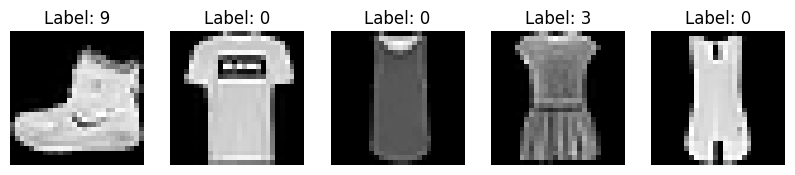

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')  
    plt.title(f'Label: {y_train[i]}')  
    plt.axis('off')  

plt.show()

In [4]:
def scale_images(train, test):
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    train_norm = train_norm / 127.5 - 1
    test_norm = test_norm / 127.5 - 1
    return train_norm, test_norm
x_train, x_test = scale_images(x_train, x_test)

In [5]:
np.random.shuffle(x_train)
np.random.shuffle(x_test)

# GENERADOR

In [6]:
from keras.models import Sequential
from keras.layers import BatchNormalization

In [ ]:
def build_generator():
  model = Sequential()

  #toma valores random y los convierte en 7x7x128 - comienzo de generación de imágenes
  model.add(Dense(7*7*128, input_dim=128))  #para convertir los 128 valores random en imagenes de 7x7 (darles algo de dimensión espacial)
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Reshape((7, 7, 128)))

  
  model.add(Conv2DTranspose(128,4,strides=2, padding='same')) #128 unidades para preservar el número de canales
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())

  model.add(Conv2DTranspose(1,4,strides=2,padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())

  # podríamos parar si pusiéramos 1 unidad en vez de 128 aquí porque ya conseguiríamos 28x28x1 pero voy a seguir construyendo
  model.add(Conv2D(128, 4, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))

  model.add(Conv2D(128,4,padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
    
  model.add(Conv2D(1, 4, padding='same', activation='tanh')) #1 kernel de tamaño 4x4, padding=same indica que mantendremos 28x28
  return model

In [8]:
generator = build_generator()
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 1)           │           2,049 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 128)         │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,340,422 (5.11 MB)

 Trainable params: 1,340,164 (5.11 MB)

 Non-trainable params: 258 (1.01 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


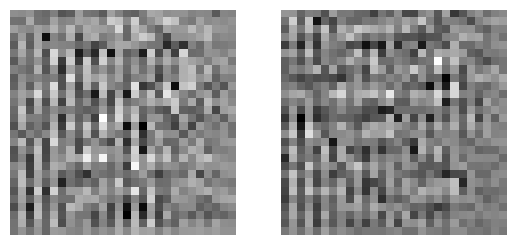

In [9]:
img = generator.predict(np.random.randn(2, 128))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(img[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

In [10]:
img.shape

(2, 28, 28, 1)

# DISCRIMINADOR

In [ ]:
def build_discriminator():
  model = Sequential()

  
  model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))  #32 filtros de tamaño 5x5. El input_shape es el tamaño de la imagen generada que le pasamos al discriminador - queremos un output compuesto por un numero
  model.add(layers.LeakyReLU(0.2))
  model.add(Dropout(0.4))

  
  model.add(Conv2D(64, 5))
  model.add(layers.LeakyReLU(0.2))
  model.add(Dropout(0.4))

  
  model.add(Conv2D(128, 5))
  model.add(layers.LeakyReLU(0.2))
  model.add(Dropout(0.4))

  
  model.add(Conv2D(256, 5))
  model.add(layers.LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Aplanar y pasar a capa densa
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='tanh')) #1 neurona con activación sigmoide para clasificar entre real o falsa
  return model

In [12]:
discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          36,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
img = img[0]

In [14]:
img.shape

(28, 28, 1)

In [15]:
discriminator.predict(np.expand_dims(img, axis=0))  #resultado 0.49, no está muy seguro de si es real o no

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


array([[1.9959005e-05]], dtype=float32)

# ENTRENAMIENTO PERSONALIZADO
## Construimos un bucle de entrenamiento nosotros mismos porque debemos entrenar dos redes a la vez, y eso sólo con *fit* no se puede.

## Establecer pérdidas y optimizadores

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [17]:
g_opt = Adam(learning_rate=0.0001) #el learning rate del generador será mayor que el del discriminador de manera que el segundo no sobrepase al primero
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

## Construir el modelo subclase

In [ ]:
class FashionGAN (Model):
  def __init__(self,generator, discriminator,*args,**kwargs):  #args y kwargs sirven por si quiero pasar algun argumento adicional
    super().__init__(*args,**kwargs) #pasar mediante args y kwargs a la clase base
    #Crear atributos para el generador y discriminador para podernos referir a ellos de esa manera dentro del modelo
    self.generator = generator
    self.discriminator = discriminator
    pass
  def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
    #compilar con la clase base
    super().compile(*args,**kwargs)
    # Crear atributos para optimizadores y pérdidas
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss
    pass
  def train_step(self,batch):#en nuestro caso, un lote de imágenes de 28x28x1 constará de 128 de ellas
    #tomar datos
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128)),training=False) #generamos 128 imágenes falsas en forma de ruido, que será el input del generador. training=false porque de momento entrenamos, solo generamos
    #Entrenar el discriminador.
    with tf.GradientTape() as d_tape:
      datosreal = self.discriminator(real_images,training=True)
      datosfake = self.discriminator(fake_images,training=True)
      datosrealfake = tf.concat([datosreal, datosfake], axis=0)
        
      #Crear etiquetas para reales y falsas
      etiquetasrealfake = tf.concat([tf.zeros_like(datosreal), tf.ones_like(datosfake)], axis=0) #las imágenes reales serán 0 y las falsas, 1
      #Añadir ruido a las etiquetas verdaderas
      noise_real = 0.15*tf.random.uniform(tf.shape(datosreal)) #añadir algo a los 0s
      noise_fake = -0.15*tf.random.uniform(tf.shape(datosfake)) #reducir algo los 1s
      etiquetasrealfake += tf.concat([noise_real, noise_fake], axis=0)
      #Calcular pérdida (Entropía binaria)
      total_d_loss = self.d_loss(etiquetasrealfake, datosrealfake)

    #Aplicar retropropagación
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) #podemos usar d_tape para calcular el gradiente mediante el total_d_loss. Queremos calcular el gradiente para cada una de las variables entrenables
    self.d_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables)) #aplica la retropropagación con los gradientes de antes. Zip es para indicar que lo queremos hacer respecto a cada trainable variable

    #Entrenar generador
    with tf.GradientTape() as g_tape:
      #Generar nuevas imágenes
      new_images = self.generator(tf.random.normal((128, 128,1)),training=True)
      #Crear etiquetas predichas
      predicted_labels = self.discriminator(new_images,training=False) #no queremos que el discriminador aprenda mientras entreno al generador. Buscamos que este vector sea todo de 1s, ya que implica que el discriminador ha detectado todas las imágenes falsas
      #calcular pérdida
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) #queremos que el generador engañe al discriminador, por lo que queremos que prediga 0s. Recompensamos al generador por engañar al discriminador, es decir, cuando el discriminador etiqueta a las imágenes generadas como 0s (reales)

    #Aplicar retropropagación (análogo al discriminador)
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))

    return {"d_loss":total_d_loss, "g_loss":total_g_loss}


In [19]:
redfashion = FashionGAN(generator, discriminator)

In [20]:
redfashion.compile(g_opt, d_opt, g_loss, d_loss)

## Construir retrollamada

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

carpeta = "resultados"

if not os.path.exists(carpeta):
    os.makedirs(carpeta)

print(f"Carpeta '{carpeta}' creada o ya existente.")


Carpeta 'resultados' creada o ya existente.


In [22]:
class ModelMonitor(Callback):                             #genera y guarda 3 imágenes tras cada época
  def __init__(self,num_img=3, latent_dim=128, save_interval=10,output_dir='/kaggle/working/resultados'):
    self.num_img = num_img
    self.latent_dim = latent_dim
    self.save_interval = 10
    self.output_dir='/kaggle/working/resultados'

  def on_epoch_end(self, epoch, logs=None):
   if (epoch + 1) % self.save_interval == 0:
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim,1)) #genera 3 imágenes, cuyo espacio latente tenga dim=128 valores aleatorios
    generated_images = self.model.generator(random_latent_vectors) #pasa los valores de antes al generador
    generated_images *=255 #invertir el escalado
    generated_images.numpy() #convertimos el vector de imágenes en un vector numpy (formato típico de imágenes)
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('resultados', f'generated_img_{epoch}_{i}.png'))

In [23]:
history = redfashion.fit(x_train, epochs=150,callbacks = [ModelMonitor()],batch_size=128) #d_loss y g_loss deben equilibrarse

Epoch 1/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 92ms/step - d_loss: 2.2359 - g_loss: 0.0041
Epoch 2/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - d_loss: 1.5578 - g_loss: 0.0487
Epoch 3/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - d_loss: 1.1989 - g_loss: 0.1291
Epoch 4/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - d_loss: 0.9506 - g_loss: 0.2897
Epoch 5/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - d_loss: 0.7641 - g_loss: 0.4175
Epoch 6/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - d_loss: 0.8749 - g_loss: 0.2813
Epoch 7/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - d_loss: 0.7550 - g_loss: 0.3642
Epoch 8/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - d_loss: 0.7827 - g_loss: 0.3638
Epoch 9/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - d_loss: 0.7448 - g_loss: 0.3617
Epoch 10/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - d_loss: 0.7186 - g_loss: 0.4708
Epoch 11/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - d_loss: 0.7170 - g_loss: 0.4426
Epoch 12/150
469/46

#### Las imágenes generadas se van almacenando en la carpeta "imagenes", de donde puedo descargarlas

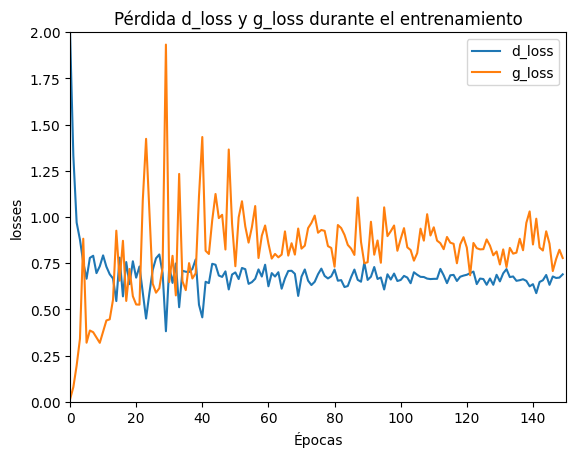

In [25]:
import matplotlib.pyplot as plt
d_loss_values = history.history['d_loss']
g_loss_values = history.history['g_loss']
plt.plot(d_loss_values, label='d_loss')
plt.plot(g_loss_values, label='g_loss')
plt.title('Pérdida d_loss y g_loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('losses')
plt.xlim(0,150)   # Límite del eje X (0 al número de épocas)
plt.ylim(0, 2)
plt.legend()
plt.show()

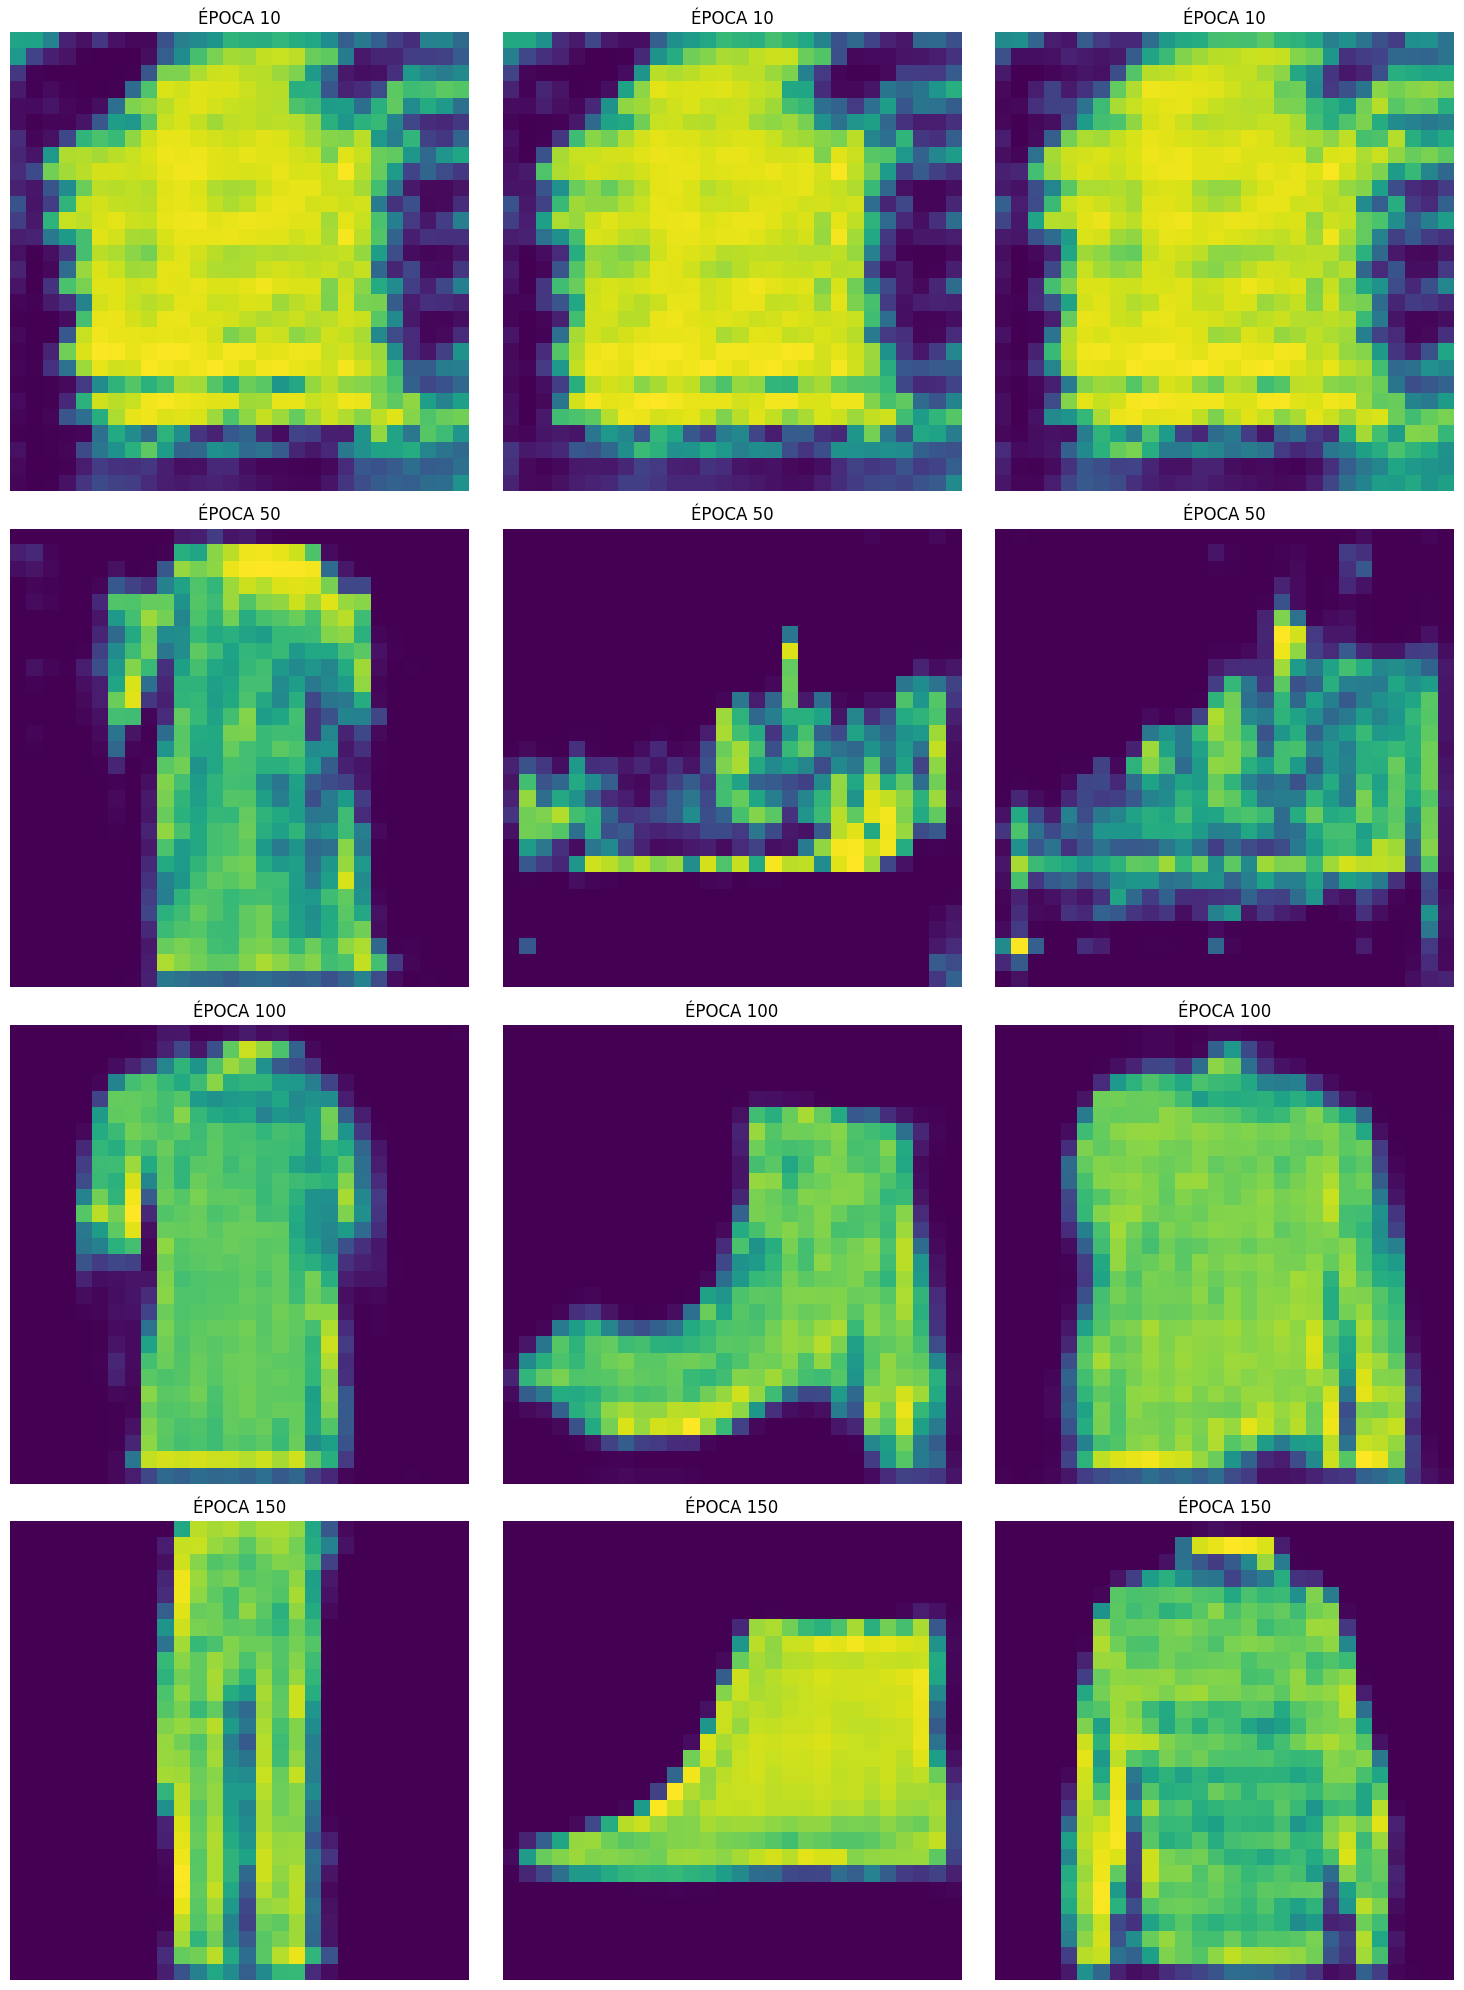

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

image_paths = [
    '/kaggle/working/resultados/generated_img_9_0.png',
    '/kaggle/working/resultados/generated_img_9_1.png',
    '/kaggle/working/resultados/generated_img_9_2.png',
    '/kaggle/working/resultados/generated_img_49_0.png',
    '/kaggle/working/resultados/generated_img_49_1.png',
    '/kaggle/working/resultados/generated_img_49_2.png',
    '/kaggle/working/resultados/generated_img_99_0.png',
    '/kaggle/working/resultados/generated_img_99_1.png',
    '/kaggle/working/resultados/generated_img_99_2.png',
    '/kaggle/working/resultados/generated_img_149_0.png',
    '/kaggle/working/resultados/generated_img_149_1.png',
    '/kaggle/working/resultados/generated_img_149_2.png',
]


num_images = len(image_paths)

num_cols = 3
num_rows = (num_images + num_cols - 1) // num_cols  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, image_path in enumerate(image_paths):
    try:
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')  
        if i < 3:
            axes[i].set_title('ÉPOCA 10')  
        elif i < 6:
            axes[i].set_title('ÉPOCA 50') 
        elif i < 9:
            axes[i].set_title('ÉPOCA 100')
        else: 
            axes[i].set_title('ÉPOCA 150')  
    except Exception as e:
        print(f"Error cargando la imagen {image_path}: {e}")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# Predicciones

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


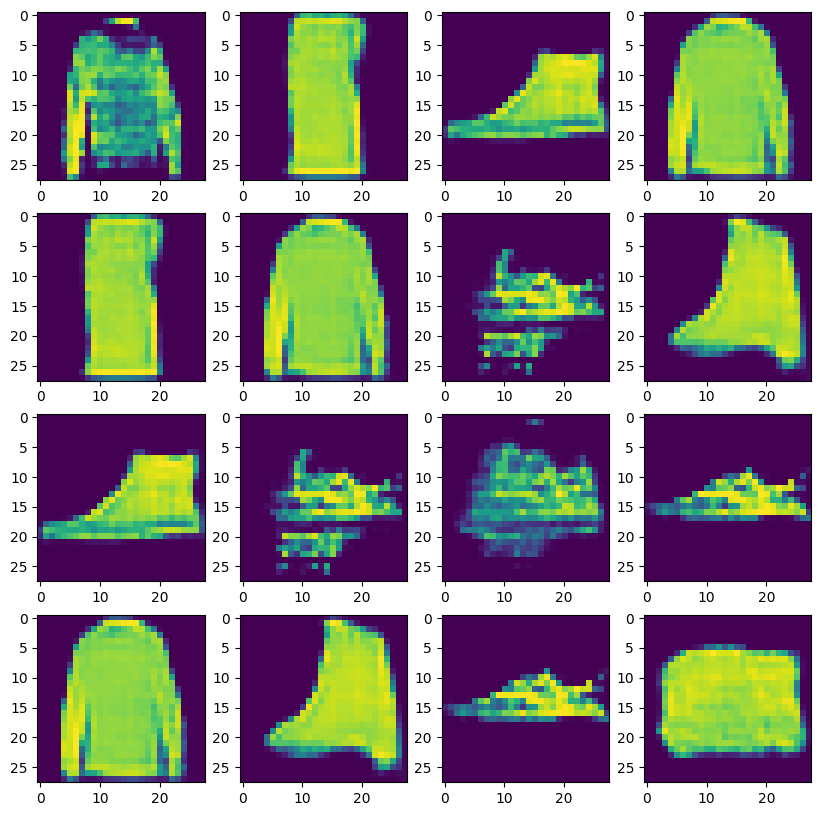

In [ ]:
imgs = generator.predict(tf.random.normal((16,128))) #generar 16 imágenes que pasamos por las 128 variables latentes
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [43]:
x_train.shape

(60000, 28, 28)

# **WCGAN**

In [1]:
import pandas as pd
import tensorflow
import keras as keras
from tensorflow import keras
from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import Dense , Flatten, UpSampling2D, Conv2D, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.datasets import fashion_mnist
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import os
import re
import warnings

import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.src import backend
from keras.src.api_export import keras_export
from keras.src.callbacks.callback import Callback
from keras.src.utils import file_utils
from keras.src.utils import io_utils
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization
from keras.models import Sequential

In [ ]:
ds = tensorflow.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = ds.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def scale_images(train, test):
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    train_norm = train_norm / 127.5 - 1
    test_norm = test_norm / 127.5 - 1
    return train_norm, test_norm
x_train, x_test = scale_images(x_train, x_test)
np.random.shuffle(x_train)

In [ ]:
def build_generator():
  model = Sequential()

  #toma valores random y los convierte en 7x7x128 - comienzo de generación de imágenes
  model.add(Dense(7*7*128, input_dim=128))  #para convertir los 128 valores random en imagenes de 7x7 (darles algo de dimensión espacial)
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Reshape((7, 7, 128)))

  # Remuestreo hacia arriba - hacia tamaño 28x28x1
  model.add(Conv2DTranspose(128,4,strides=2, padding='same')) #128 unidades para preservar el número de canales
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())

  model.add(Conv2DTranspose(1,4,strides=2,padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())

  # podríamos parar si pusiéramos 1 unidad en vez de 128 aquí porque ya conseguiríamos 28x28x1 pero voy a seguir construyendo
  model.add(Conv2D(128, 4, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))

  model.add(Conv2D(128,4,padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
    
  #capa convolucional para obtener 1 canal
  model.add(Conv2D(1, 4, padding='same', activation='tanh')) #1 kernel de tamaño 4x4, padding=same indica que mantendremos 28x28
  return model

In [5]:
generator = build_generator()
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 1)           │           2,049 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 128)         │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,340,422 (5.11 MB)

 Trainable params: 1,340,164 (5.11 MB)

 Non-trainable params: 258 (1.01 KB)

In [ ]:
def build_critic():
  model = Sequential()

  model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))  #32 filtros de tamaño 5x5. El input_shape es el tamaño de la imagen generada que le pasamos al discriminador - queremos un output compuesto por un numero
  model.add(layers.LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(64, 5))
  model.add(layers.LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(128, 5))
  model.add(layers.LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(256, 5))
  model.add(layers.LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='tanh')) #1 neurona con activación sigmoide para clasificar entre real o falsa
  return model

In [7]:
critic = build_critic()
critic.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          36,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def gradient_penalty(self, batch_size, real_images, fake_images):
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)  #genera un tensor de nºs aleatorios de tamaño (batch_sz,1,1,1) llamado alpha, a partir de una normal(0,1)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff  #creamos imágenes ficticias entre las reales y falsas, controlándo cuánta mezcla hay en cada interpolación con alpha
    
    with tf.GradientTape() as gp_tape:  #cálculo del gradiente
        gp_tape.watch(interpolated)
        pred = self.critic(interpolated, training=True) #obtiene la predicción del crítico
        
    grads = gp_tape.gradient(pred, [interpolated])[0]  #cálculo del gradiente de la prediccion vs interpolacion
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))  #norma L2 de los gradientes
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp  #la función devuelve la distancia entre la norma L2 Y 1 media al cuadrado

In [9]:
g_opt = Adam(learning_rate=0.0001) #el learning rate del generador será mayor que el del discriminador de manera que el segundo no sobrepase al primero
c_opt = Adam(learning_rate=0.00001)

In [ ]:
class FashionWGAN(Model):
  def __init__(self,generator, discriminator,*args,**kwargs):  #args y kwargs sirven por si quiero pasar algun argumento adicional
    super().__init__(*args,**kwargs) #pasar mediante args y kwargs a la clase base
    #Crear atributos para el generador y discriminador para podernos referir a ellos de esa manera dentro del modelo
    self.generator = generator
    self.critic = critic
    pass
  def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
    #compilar con la clase base
    super().compile(*args,**kwargs)
    # Crear atributos para optimizadores y pérdidas
    self.g_opt = g_opt
    self.c_opt = c_opt
    self.g_loss = g_loss
    self.c_loss = c_loss
    pass
def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]  #obtención del tamaño de lote
    
    # Entrenamiento del crítico
    for i in range(3):  #entrena al crítico por 3 veces antes de comenzar a entrenar el generador.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))   #vector latente aleatorio de tamaño (batch_size, latent_dim) usando una distribución normal
        fake_images = self.generator(random_latent_vectors, training=True)  #el generador crea imágenes falsas a partir del vector anterior
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)  #el generador crea imágenes falsas a partir del vector anterior
            fake_predictions = self.critic(fake_images, training=True) #el crítico evalúa las imágenes falsas y da una predicción
            real_predictions = self.critic(real_images, training=True) #el crítico evalúa las imágenes reales y da una predicción
            
            c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)  #pérdida Wass para el crítico. El objetivo del crítico es hacer esta diferencia lo mayor posible
            c_gp = self.gradient_penalty(batch_size, real_images, fake_images) #penalización de gradiente
            c_loss = c_wass_loss + c_gp * self.gp_weight #pérdida total del crítico
        
        c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)  #calculo los gradientes de la pérdida total
        self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables)) #aplico los gradientes
    
    
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) #otro vector latente para alimentar al generador
    
    with tf.GradientTape() as tape:  
        fake_images = self.generator(random_latent_vectors, training=True) #genera imágenes falsas
        fake_predictions = self.critic(fake_images, training=True)  #crítico evalúa las imágenes falsas
        
        g_loss = -tf.reduce_mean(fake_predictions) #El objetivo del generador es minimizar esta pérdida, lo que equivale a hacer que el crítico clasifique las imágenes falsas como reales
    
    gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables) #análogo
    self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables)) #análogo
    
    
    self.c_loss_metric.update_state(c_loss) 
    self.c_wass_loss_metric.update_state(c_wass_loss)
    self.c_gp_metric.update_state(c_gp)
    self.g_loss_metric.update_state(g_loss)
    
    return {m.name: m.result() for m in self.metrics}


In [11]:
redFASHIONWGAN = FashionWGAN(generator, critic)

In [14]:
redFASHIONWGAN.compile(g_opt,c_opt,g_loss,c_loss)

NameError: name 'g_loss' is not defined

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback


carpeta = "resultados"

if not os.path.exists(carpeta):
    os.makedirs(carpeta)

print(f"Carpeta '{carpeta}' creada o ya existente.")


Carpeta 'resultados' creada o ya existente.


In [16]:
class ModelMonitor(Callback):                             #genera y guarda 3 imágenes tras cada época
  def __init__(self,num_img=3, latent_dim=128, save_interval=10,output_dir='/kaggle/working/resultados'):
    self.num_img = num_img
    self.latent_dim = latent_dim
    self.save_interval = 10
    self.output_dir='/kaggle/working/resultados'

  def on_epoch_end(self, epoch, logs=None):
   if (epoch + 1) % self.save_interval == 0:
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim,1)) #genera 3 imágenes, cuyo espacio latente tenga dim=128 valores aleatorios
    generated_images = self.model.generator(random_latent_vectors) #pasa los valores de antes al generador
    generated_images *=255 #invertir el escalado
    generated_images.numpy() #convertimos el vector de imágenes en un vector numpy (formato típico de imágenes)
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('resultados', f'generated_img_{epoch}_{i}.png'))

In [17]:
history = redFASHIONWGAN.fit(x_train, epochs=10,callbacks = [ModelMonitor()],batch_size=128) #d_loss y g_loss deben equilibrarse

ValueError: You must call `compile()` before using the model.